In [1]:
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._children:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

In [85]:

"""
suppose you have this expression : 
x = b + d 
f = a * x + c 

the tree is gonna look something like this : 


 +-------------------+f +--------------------+  
 |                   ++-+                    |  
 |                    |                      |  
 |                    |                      |  
 v                    v                      v  
+--+      +--+      +---+       +----+     +---+
| a|      |* |  +---+ x +---+   |  + |     | c |
+--+      +--+  |   +-+-+   |   +----+     +---+
                |     |     |                   
                |     |     |                   
                |     |     |                   
                v     v     v                   
              +--+   +--+  +--+                 
              |b |   |+ |  | d|                 
              +--+   +--+  +--+                 



f._children = {a, x, c}

**grad: 
s --> c ---> f 

ds/df = ds/dc * dc/df 



"""
class Value:
    def __init__(self, value):
        self.data = value
        self.grad = 0.0
        self._children = set()
        self._op = ""
        self.label = ""
        self._backward = lambda : None
            
    def __repr__(self):
        out = f"Value(data={self.data}, grad={self.grad}, children={self._children})"
        return out 

    def __add__(self, other):
        res = self.data + other.data
        out = Value(res)
        out._children.update([self, other])  
        out._op = "+"    
        
        def compute_grad(): 
            for child in out._children:
                child.grad = out.grad         
        
        out._backward = compute_grad 
        return out
    
    def __mul__(self, other): 
        res = self.data * other.data
        out = Value(res)
        out._op = "*"
        out._children.update([self, other])    
        def compute_grad(): 
            total_power = 1.0
            for child in out._children:
                total_power *= child.data
            for child in out._children: 
                child.grad = out.grad * (total_power / child.data) 
        
        out._backward = compute_grad
        return out 

In [86]:
h = 0.001


a = Value(2.0) 
b = Value(3.0)
c = a + b 
d = Value(6.0)
f = d * c 

a.label = "a"
f.label = "f"
d.label = "d"
b.label = "b" 
c.label = "c"


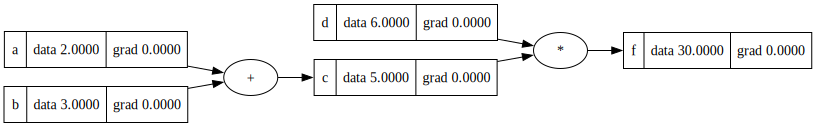

In [87]:
draw_dot(f)

In [88]:
f.grad = 1.0

def backprop(root : Value): 
    root._backward()
    for child in root._children: 
        backprop(child)

backprop(f)
    

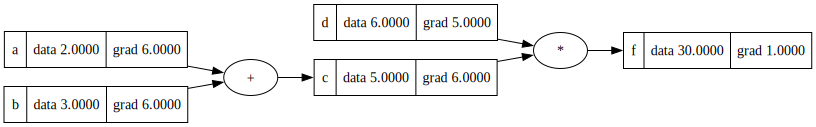

In [89]:
draw_dot(f)

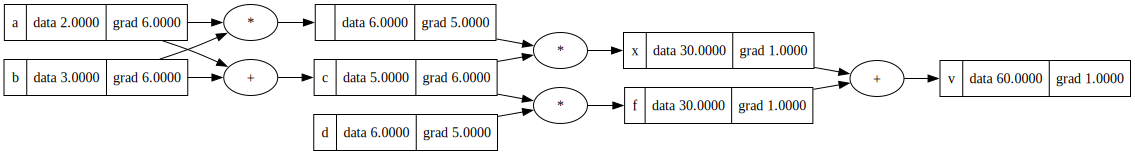

In [92]:
x = a * b * c
v = x + f 
v.label = "v"
x.label = "x"


# dv/da = b*c
v.grad = 1.0
backprop(v)

draw_dot(v)